In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from anzu.emu_funcs import LPTEmulator

%load_ext autoreload
%autoreload 2


In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'

plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18

colors = ['#8d598f', '#cd9b00', '#de2d26', '#004d00', '#3182bd'][::-1]

The `LPTEmulator` object is the class that does all of our work. The emulator is trained on the default simulation data with fiducial parameters from 2101.11014 upon instantiation. 

It is possible to tweak some settings with kwargs provided to the `LPTEmulator` object, but this is generally not recommended unless you have very good reason to.


# Anzu's original settings

In [3]:
st = time.time()
emu = LPTEmulator()

/home/nick/miniconda3/envs/cosmo/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:324: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)


Now we're ready to make predictions. The default emulator makes predictions as a function of \\(\Omega_b h^2,\, \Omega_c h^2,\, w,\, n_s,\, \sigma_8,\, H_0,\, N_{\rm eff},\, a\\) in that order. You will also need to provide an array of wavenumbers that you want to compute spectra at, which should be in units of \\(h^{-1}\rm Mpc\\).

In [4]:
k = np.logspace(-2,0,100)
cosmo_vec = np.atleast_2d([0.023, 0.108, -0.73, 0.98, 0.69,  63.2,  2.95,  1.0])

emu_spec = emu.predict(k, cosmo_vec)

We can also read in the Aemulus test cosmologies and measure the emulators accuracy on a set of simulations that it is not trained on. 

In [5]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

# this is a helper function to set up an array to make predictions for all redshifts that there 
# are Aemulus snapshots for all Aemulus test cosmologies. It's not necessary to use this for 
# arbitrary cosmologies/redshifts. 

In [6]:
pce_spec = emu.predict(k, np.atleast_2d(design_test))

Now we can plot the predictions, here just for \\( z=0\\) for the 7 test cosmologies.

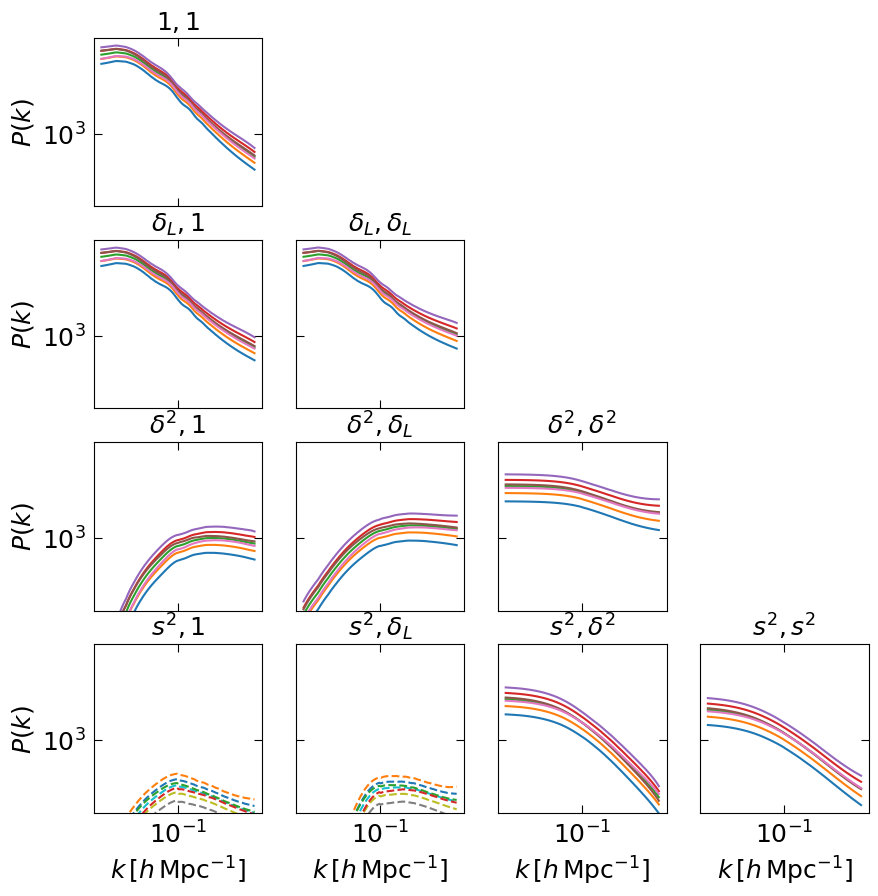

In [7]:
f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
components = ['1', '\delta_L', '\delta^2', 's^2']

pce_spec_reshape = pce_spec.reshape(7, 9, 10, -1)

#plot z=0 predictions
z_idx = -1 

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].loglog(k, pce_spec_reshape[:,z_idx,counter,:].T)
        l0 = ax[i,j].loglog(k, -pce_spec_reshape[:,z_idx,counter,:].T, ls='--')

        counter += 1
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))

        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'$P(k)$')


f.set_figheight(10)
f.set_figwidth(10)


For something a little more complicated, we can also test the accuracy of the emulator against the measured spectra from the Aemulus test boxes. Here we remake one of the accuracy figures from the original paper.

In [8]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load('{}/cleft_spectra_test.npy'.format(dirname))
spectra_aem_test = np.load('{}/spectra_aem_test_compensated_fixedgrowth.npy'.format(dirname))
spectra_aem_test_mean = np.nanmean(spectra_aem_test, axis=1)

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(spectra_lpt_test)
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx

spectra_aem_reshape = spectra_aem_test_mean[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_lpt_test_reshape = spectra_lpt_test[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_aem_test_mean = spectra_aem_test_mean[:,zidx:,...]


/home/nick/miniconda3/envs/cosmo/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:324: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)


In [9]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec = emu.predict(emu.k[:emu.kmax_idx], design_test, spectra_lpt=spectra_lpt_test_reshape)
pce_spec = pce_spec.reshape(7, emu.nz, 10, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec = emu.predict(emu.k[:emu.kmax_idx], design_test, spectra_lpt=spectra_lpt_test_reshape,
                                   evec_spec=emu.evec_spec[...,:2], simoverlpt=simoverlpt_test)
pca_spec = pca_spec.reshape(7, emu.nz, 10, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])

counter = 0
dk = k[1:] - k[:-1]

for i in range(4):
    for j in range(4):
        if j>i:
            continue

        for ki in range(nz):
            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]

        counter+=1

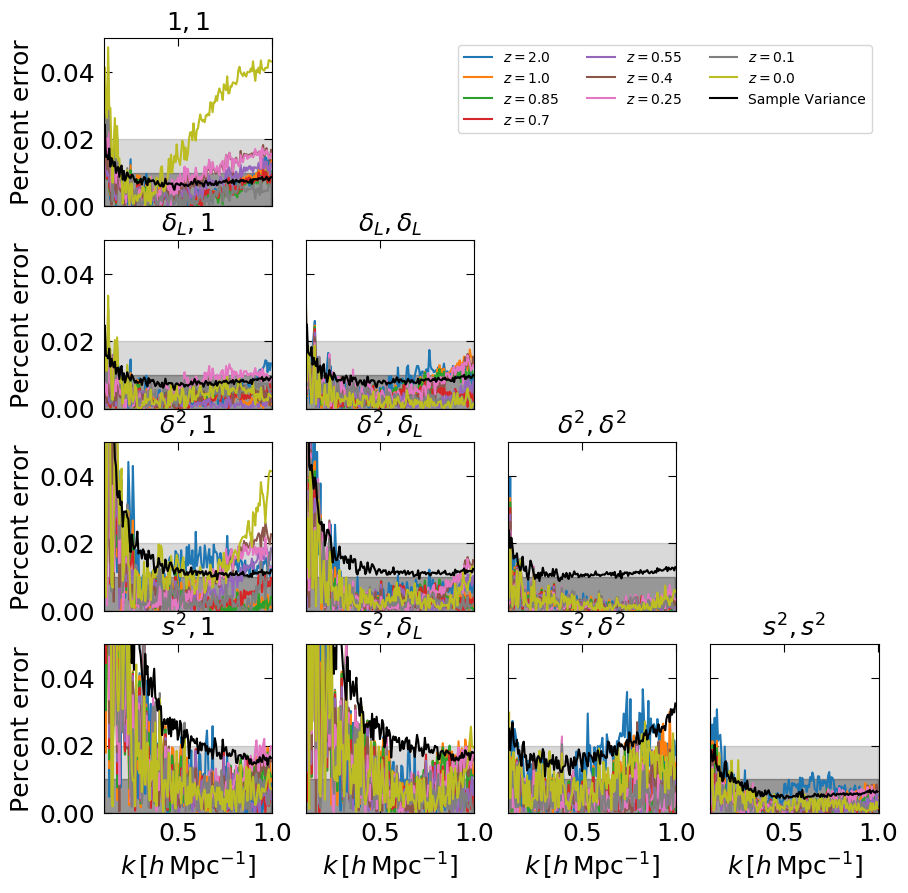

In [10]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.abs(resids_emu[tbcount,:,counter,kmin_idx:kmax_idx].T))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


In [11]:
print('Running through all of CLEFT took ',  time.time() - st)

Running through all of CLEFT took  221.2163712978363


# Anzu with 'k-Expanded CLEFT' (KECLEFT)

Below we present the same residual plots as above but with a new experimental setting in Anzu. Instead of using the fully resummed CLEFT predictions from `velocileptors` we use a new module that performs `k-expanded CLEFT` (KECLEFT), detailed in Appendix E of https://arxiv.org/pdf/2005.00523.pdf . Calculations in KECLEFT are significantly faster than standard CLEFT, especially when varying redshift and keeping cosmology the same. 

The cells below show the performance of a KECLEFT-based emulator. Note that we don't change the settings compared to what was originally settled on in our paper, so there could be room for improvement. 

Switching to KECLEFT mode is as simple as initializing an `LPTEmulator` with `kecleft=True`. 
**Caveat emptor: this version is still experimental and not incredibly verified. Use it at your own risk or get in touch with one of the Anzu developers if you have questions.**

In [12]:
st = time.time()

emu = LPTEmulator(kecleft=True)

/home/nick/miniconda3/envs/cosmo/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:143: UserWarning: kecleft and extrap are both set. Setting extrap to False.
  warnings.warn("kecleft and extrap are both set. Setting extrap to False.")
/home/nick/miniconda3/envs/cosmo/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:324: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)


Now we're ready to make predictions. The default emulator makes predictions as a function of \\(\Omega_b h^2,\, \Omega_c h^2,\, w,\, n_s,\, \sigma_8,\, H_0,\, N_{\rm eff},\, a\\) in that order. You will also need to provide an array of wavenumbers that you want to compute spectra at, which should be in units of \\(h^{-1}\rm Mpc\\).

In [13]:
k = np.logspace(-2,0,100)
cosmo_vec = np.atleast_2d([0.023, 0.108, -0.73, 0.98, 0.69,  63.2,  2.95,  1.0])

emu_spec = emu.predict(k, cosmo_vec)

We can also read in the Aemulus test cosmologies and measure the emulators accuracy on a set of simulations that it is not trained on. 

In [14]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

# this is a helper function to set up an array to make predictions for all redshifts that there 
# are Aemulus snapshots for all Aemulus test cosmologies. It's not necessary to use this for 
# arbitrary cosmologies/redshifts. 

In [15]:
pce_spec = emu.predict(k, np.atleast_2d(design_test))

Now we can plot the predictions, here just for \\( z=0\\) for the 7 test cosmologies.

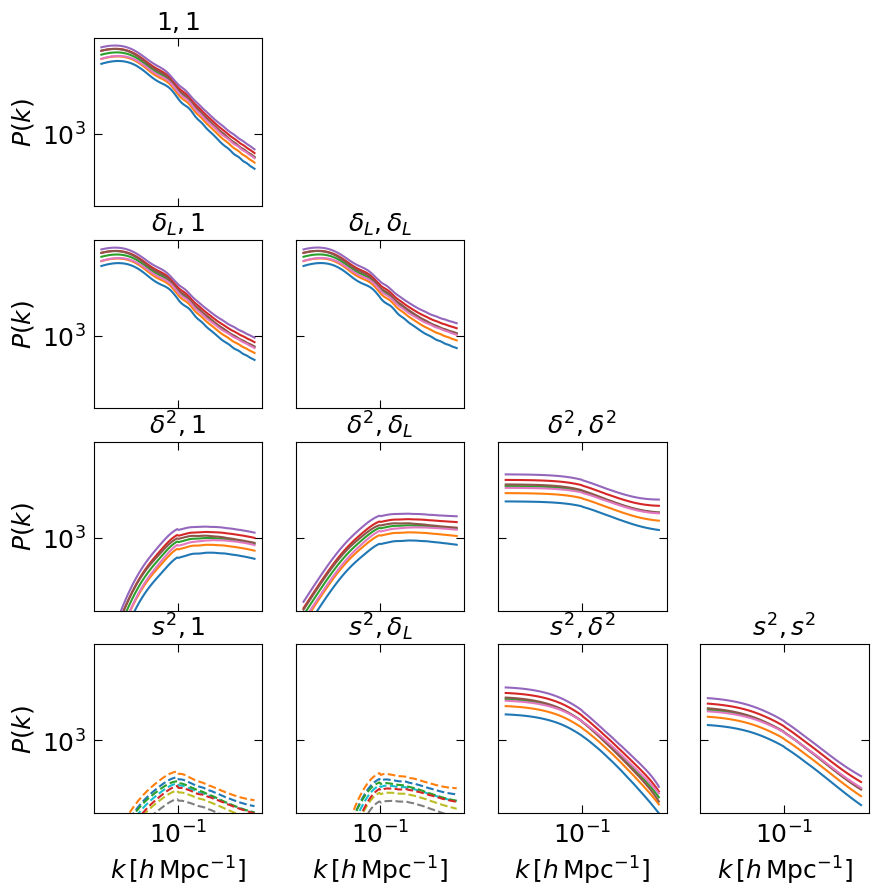

In [16]:
f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
components = ['1', '\delta_L', '\delta^2', 's^2']

pce_spec_reshape = pce_spec.reshape(7, 9, 10, -1)

#plot z=0 predictions
z_idx = -1 

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].loglog(k, pce_spec_reshape[:,z_idx,counter,:].T)
        l0 = ax[i,j].loglog(k, -pce_spec_reshape[:,z_idx,counter,:].T, ls='--')

        counter += 1
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))

        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'$P(k)$')


f.set_figheight(10)
f.set_figwidth(10)


For something a little more complicated, we can also test the accuracy of the emulator against the measured spectra from the Aemulus test boxes. Here we remake one of the accuracy figures from the original paper.

In [17]:
cosmos_test_file = 'test_cosmos.txt'
design_test, design_test_scaled = emu._setup_design(cosmos_test_file)

#read in CLEFT and Aemulus spectra for test cosmologies
dirname = '/'.join([os.path.abspath(''),'../anzu/data'])
spectra_lpt_test = np.load('{}/kecleft_spectra_test.npy'.format(dirname))
spectra_aem_test = np.load('{}/spectra_aem_test_compensated_fixedgrowth.npy'.format(dirname))
spectra_aem_test_mean = np.nanmean(spectra_aem_test, axis=1)

#Set up some data for tests of PCA only 
spectra_lpt_test_extrap = emu._powerlaw_extrapolation(spectra_lpt_test)
simoverlpt_test = emu._ratio_and_smooth(spectra_aem_test_mean, spectra_lpt_test_extrap)

zidx = emu.zidx

spectra_aem_reshape = spectra_aem_test_mean[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_lpt_test_reshape = spectra_lpt_test[:,zidx:,...].reshape(7 * emu.nz, 10, -1)
spectra_aem_test_mean = spectra_aem_test_mean[:,zidx:,...]


/home/nick/miniconda3/envs/cosmo/lib/python3.8/site-packages/anzu-1.0-py3.8.egg/anzu/emu_funcs.py:324: RuntimeWarning: invalid value encountered in log10
  simoverlpt = np.log10(simoverlpt)


In [18]:
# Here is an example of how to make predictions when you have pure LPT spectra already computed by passing them in
# to the spectra_lpt kwarg of the predict function.

pce_spec = emu.predict(emu.k[:emu.kmax_idx], design_test)
pce_spec = pce_spec.reshape(7, emu.nz, 10, -1)

# Another variation of how to call predict, this time testing what happens if we want to make predictions
# Given the true PC components. This measures the accuracy of the PCA portion of the emulator.
pca_spec = emu.predict(emu.k[:emu.kmax_idx], design_test,
                                   evec_spec=emu.evec_spec[...,:2], simoverlpt=simoverlpt_test)
pca_spec = pca_spec.reshape(7, emu.nz, 10, -1)

kmax_idx = emu.kmax_idx
kmin_idx = emu.kmin_idx
k = emu.k
nz = emu.nz

resids_emu = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])
resids_pca = np.zeros_like(spectra_aem_test_mean[...,:kmax_idx])

counter = 0
dk = k[1:] - k[:-1]

for i in range(4):
    for j in range(4):
        if j>i:
            continue

        for ki in range(nz):
            resids_emu[:,ki,counter,:kmax_idx] = (pce_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]
            resids_pca[:,ki,counter,:kmax_idx] = (pca_spec[:,ki,counter,:] - spectra_aem_test_mean[:,ki,counter,:kmax_idx])/spectra_aem_test_mean[:,ki,counter,:kmax_idx]

        counter+=1

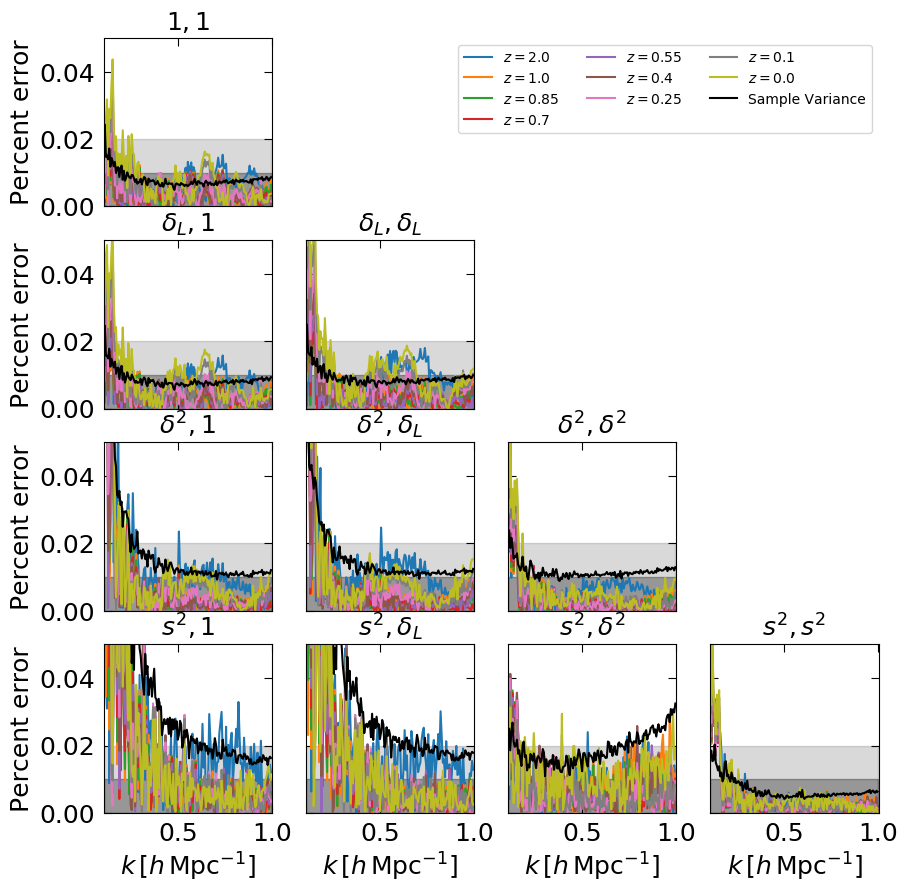

In [19]:
varpk = np.nanmean(np.nanstd(spectra_aem_test, axis=1), axis=(0,1))
meanpk = np.nanmean(np.nanmean(spectra_aem_test, axis=1), axis=(0,1))

f, ax = plt.subplots(4,4, sharex=True, sharey=True, facecolor='w')
counter = 0
tbcount = 3
components = ['1', '\delta_L', '\delta^2', 's^2']

for i in range(4):
    for j in range(4):
        if j>i: 
            ax[i,j].axis('off')
            continue
            
        l0 = ax[i,j].plot(k[kmin_idx:kmax_idx], np.abs(resids_emu[tbcount,:,counter,kmin_idx:kmax_idx].T))
        l1 = ax[i,j].plot(k[kmin_idx:kmax_idx], varpk[counter, kmin_idx:kmax_idx].T/np.abs(meanpk[counter,kmin_idx:kmax_idx].T), color='k')

        counter += 1
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.01, alpha=0.3, color='k')
        ax[i][j].fill_between(k[kmin_idx:kmax_idx], np.zeros(kmax_idx-kmin_idx), 
                              np.zeros(kmax_idx-kmin_idx) + 0.02, alpha=0.15, color='k')
        
        ax[i][j].set_title((r'${},{}$'.format(components[i], components[j])))
        if i==3:
            ax[i][j].set_xlabel(r'$k\, [h\,{\rm Mpc}^{-1}]$')
        if j==0:
            ax[i][j].set_ylabel(r'Percent error')

ax[0][0].set_ylim([0, .05])
ax[0][0].set_xlim([k[kmin_idx], k[kmax_idx]])
l0.extend(l1)
#l0.extend(l2)
labels= ['$z={}$'.format(zi) for zi in emu.zs[1:]]
labels.extend([r'Sample Variance', r'Mean PCA residual'])
ax[0][3].legend(l0, labels, fontsize=10, ncol=3)
f.set_figheight(10)
f.set_figwidth(10)


In [20]:
print('Running through all of KECLEFT took ', time.time() - st)

Running through all of KECLEFT took  25.4784677028656
